In [456]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [457]:
files = glob.glob('datasets/**/*_batch*', recursive =True)

In [458]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [466]:
def get_data(file):
    data = unpickle(file)
    y= data[b'labels']
    x_v = data[b'data']
    n = len(x_v[0])//3
    x = np.concatenate([x_v.reshape(-1, 3, n)[:,i,:].reshape(-1, 32, 32, 1) for i in range(3)], axis =3)
    return x, x_v, y

In [473]:
x_v.shape

(10000, 3072)

In [467]:
x, x_v, y = get_data(files[0])

In [508]:
with tf.Session() as sess:
    y_hot = sess.run(tf.one_hot(y, depth = 10))

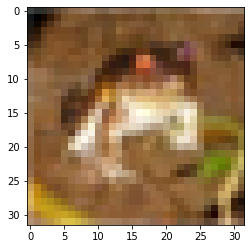

In [482]:
plt.imshow(x[0])

In [598]:
def get_params(shape):
    np.random.seed(7)
    params = dict()
    for i in range(1, len(shape)):
        params['W' + str(i)] = tf.Variable(np.random.randn(*shape[i-1: i+1]), dtype = tf.float32)
        params['b' + str(i)] = tf.Variable(np.zeros((1, shape[i])), dtype = tf.float32)
    return params

In [599]:
def linear(x, params, i = ''):
    h = tf.add(tf.matmul(x, params['W' + i]),params['b' + i])
    return h

In [600]:
def logistic(x, params):
    hs = [x]
    for i in range(1, len(params)//2 +1):
        z = linear(hs[-1], params, str(i))
        h = tf.nn.sigmoid(z)
        hs.append(h)
    
    return hs[-1]

In [613]:
def get_cost(x, y, model, params, lambd = 0, loss = 'MSE'):
    h= model(x, params)
    if loss == 'MSE':
        J = (h-y)**2
    elif loss == 'crossentropy':
        epsilon = 1e-20
        J = -(y*tf.math.log(h +epsilon) + (1-y)*tf.math.log(1-h+epsilon))
    R = 0
    for i in range(1, len(params)//2 +1): 
        R+=tf.math.reduce_sum(params['W'+str(i)] **2) 
        
    J = tf.math.reduce_mean(J) + (lambd/2)*R
    return J

In [662]:
def train(inp, out, model, shape = None , epochs = 100, lr= 1e-3, lambd = 0, loss = 'MSE', batch_size = 32):
    x = tf.placeholder(tf.float32, shape = (None, inp.shape[1]))
    y = tf.placeholder(tf.float32, shape = (None, out.shape[1]))
    if shape == None:
        shape =[x.shape[1], y.shape[1]]
    params = get_params(shape)
    costs = []
    cost = get_cost(x, y, model, params, lambd, loss)
    optimizer = tf.train.AdamOptimizer(learning_rate = lr).minimize(cost)
    init=tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(epochs):
            for i in range(len(inp)//batch_size):
                c, _ = sess.run([cost, optimizer], feed_dict={x: inp[i*batch_size:(i+1)*batch_size, :], y:out[i*batch_size:(i+1)*batch_size,:]})
            if epoch%(epochs//10) == 0:
                print('Cost at epoch ' + str(epoch), c)
            if epoch%5 == 0:
                costs.append(c)
                
        params = sess.run(params)
    
    return costs, params
        
    

In [665]:
costs, params = train(x_v.astype(np.float32), y_hot, shape = [x_v.shape[1], 20, y_hot.shape[1]], model = logistic, lr = 1e-3, loss = 'crossentropy', epochs = 100)

Cost at epoch 0 0.3355622
Cost at epoch 10 0.32049778
Cost at epoch 20 0.32067984
Cost at epoch 30 0.3236907
Cost at epoch 40 0.32419735
Cost at epoch 50 0.32433942
Cost at epoch 60 0.324317
Cost at epoch 70 0.32429415
Cost at epoch 80 0.32427078
Cost at epoch 90 0.32424802


In [ ]:
with tf.Session() as sess:
    predictions = sess.run(logistic(x_v.astype(np.float32), params))

In [ ]:
p = np.array(y) == np.argmax(predictions, axis = 1)

In [ ]:
np.sum(p)/len(p)